In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "careamics[examples]>=0.0.15",
# ]
# ///

The mouse nuclei dataset is composed of a train and test dataset.

In [1]:
# Imports necessary to execute the code
import torch
import matplotlib.pyplot as plt
import numpy as np
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from PIL import Image

In [2]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

Using GPU: yes


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [3]:
# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n20.download()
files.sort()

# load images
train_data = np.load(files[1])["X_train"]
print(f"Train data shape: {train_data.shape}")

Train data shape: (908, 128, 128)


### Data description

In [4]:
portfolio.denoiseg.MouseNuclei_n20.description

'A dataset depicting diverse and non-uniformly clustered nuclei in the mouse skull, consisting of 908 training and 160 validation patches. The test set counts 67 additional images'

### Visualize data

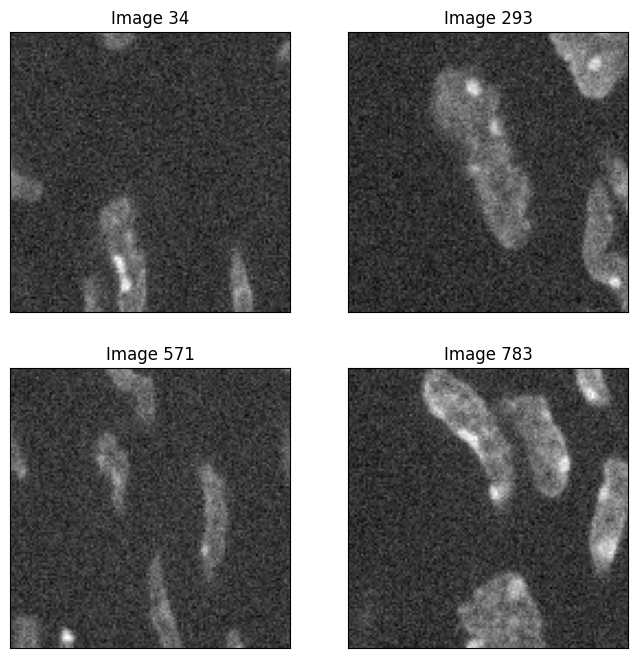

In [5]:
indices = [34, 293, 571, 783]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(train_data[indices[0]], cmap="gray")
ax[0, 0].set_title(f"Image {indices[0]}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(train_data[indices[1]], cmap="gray")
ax[0, 1].set_title(f"Image {indices[1]}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(train_data[indices[2]], cmap="gray")
ax[1, 0].set_title(f"Image {indices[2]}")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(train_data[indices[3]], cmap="gray")
ax[1, 1].set_title(f"Image {indices[3]}")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the 
various parameters available in CAREamics. However, a straightforward way to create a 
configuration for a particular algorithm is to use one of the convenience functions.

In [6]:
config = create_n2v_configuration(
    experiment_name="mouse_nuclei_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [7]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_data,
)

No working directory provided. Using current working directory: /localscratch/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [23.03012026], std: [42.2465617]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-nvpt4s-9-5904a58d5cc194a0/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /localscratch/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


Text(0.5, 1.0, 'Losses')

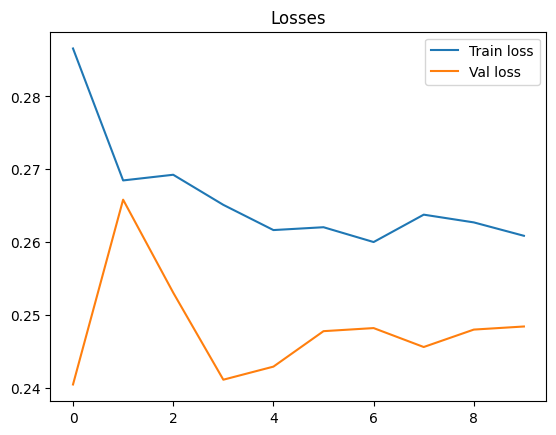

In [8]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is 
large we predict using tiling.

In [9]:
prediction = careamist.predict(source=train_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-nvpt4s-9-5904a58d5cc194a0/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

In [10]:
# download ground truth
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load images
gt_data = np.load(files[1])["X_train"]
print(f"GT data shape: {gt_data.shape}")

GT data shape: (908, 128, 128)


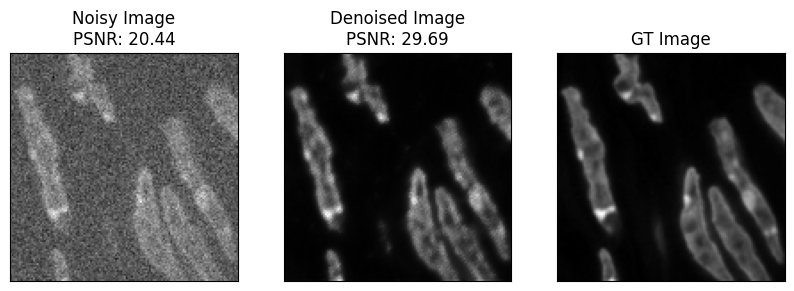

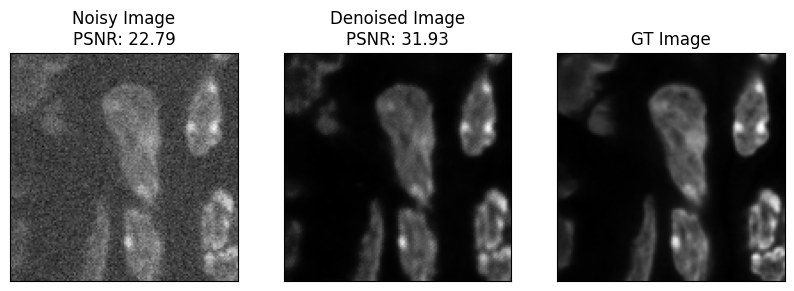

In [11]:
indices = [389, 621]

for i in indices:
    # compute psnr
    psnr_noisy = scale_invariant_psnr(gt_data[i], train_data[i])
    psnr_denoised = scale_invariant_psnr(gt_data[i], prediction[i].squeeze())

    # plot images
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(train_data[i], cmap="gray")
    ax[0].set_title(f"Noisy Image\nPSNR: {psnr_noisy:.2f}")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(prediction[i].squeeze(), cmap="gray")
    ax[1].set_title(f"Denoised Image\nPSNR: {psnr_denoised:.2f}")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].imshow(gt_data[i], cmap="gray")
    ax[2].set_title("GT Image")
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    plt.show()

### Compute metrics

In [12]:
psnrs = np.zeros(gt_data.shape[0])

for i in range(gt_data.shape[0]):
    psnrs[i] = scale_invariant_psnr(gt_data[i], prediction[i].squeeze())

print(f"PSNR: {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f}")

PSNR: 32.03 ± 2.15


## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the 
[BioImage Model Zoo](www.bioimage.io) format.

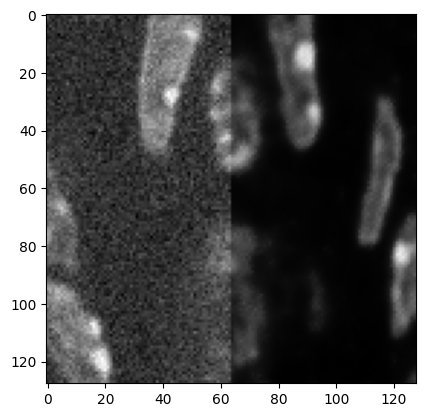

In [13]:
# create a cover image
index_cover = 5
height, width = 128, 128

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (train_data[index_cover] - train_data[index_cover].min()) / (
    train_data[index_cover].max() - train_data[index_cover].min()
)

pred = prediction[index_cover].squeeze()
norm_pred = (pred - pred.min()) / (pred.max() - pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[:height, : width // 2]
cover[:, width // 2 :] = norm_pred[:height, width // 2 :]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("MouseNuclei_Noise2Void.jpeg")

In [14]:
general_description = (
    "This model is a UNet trained with the Noise2Void algorithm to denoise images. "
    "The training data consists of images of non-uniformly clustered nuclei in the "
    "mouse skull. The notebook used to train this model is available on the CAREamics "
    "documentation website at the following link: "
    "https://careamics.github.io/0.1/applications/Noise2Void/Mouse_Nuclei/."
)
print(general_description)

This model is a UNet trained with the Noise2Void algorithm to denoise images. The training data consists of images of non-uniformly clustered nuclei in the mouse skull. The notebook used to train this model is available on the CAREamics documentation website at the following link: https://careamics.github.io/0.1/applications/Noise2Void/Mouse_Nuclei/.


In [15]:
# Export the model
careamist.export_to_bmz(
    path_to_archive="mousenuclei_n2v_model.zip",
    friendly_model_name="MouseNuclei_N2V",
    input_array=train_data[[indices[0]]].astype(np.float32),
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    data_description=portfolio.denoiseg.MouseNuclei_n20.description,
    general_description=general_description
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]

2025-10-02 09:32:20.770 | DEBUG    | bioimageio.core._resource_tests:_test_model_inference:618 - starting 'Reproduce test outputs from test inputs (pytorch_state_dict)'
2025-10-02 09:32:21.044 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:765 - Testing inference with 2 different inputs (B, N): {(1, 0), (2, 0)}
